# Import Libraries

In [ ]:
from os import listdir
from os import path
import pickle
import random
import datetime
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.models import Model
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
import tensorflow.keras as tk
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from IPython.display import Image

: 

In [ ]:
%load_ext tensorboard

# Data Engineering

In [ ]:
# function to load the images
def load_photos(directory):
    images = dict()
    for name in listdir(directory):
        print(name)
        # load image
        filename = path.join(directory, name)
        image = load_img(filename, target_size=(224,224))
        # convert image to array
        image = img_to_array(image)
        # reshape data
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # normalize images with parameters for the model
        image = preprocess_input(image)
        # get the image id
        image_id = name.split('.')[0]
        images[image_id] = image
    return images

In [ ]:
# function to run the images through the VGG model and save the features
# purpose is so that we don't have to run two models at a time later when we train the text generator
def extract_features(directory):
    # import the VGG model
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # remove the last layer of the model so that we can take those as input for the model
    model.summary()
    features = dict()
    images = load_photos(directory)
    for image_id, image in images.items():
        print(image_id)
        feature = model.predict(image, verbose=0)
        features[image_id] = feature
    return features

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
driveAuth = GoogleAuth()
driveAuth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(driveAuth)

In [ ]:
pickleFileDownloaded = drive.CreateFile({'id':'1A8g74ohdb_5d2fPjc72yF7GxufE9GRcu'})
pickleFileDownloaded.GetContentFile('set_1.pkl')

In [ ]:
import pickle

infile = open('set_1.pkl','rb')
image_captions = pickle.load(infile)
infile.close()

print(image_captions)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pandas as pd

imageNames = []
captionIds = []
captions = []
for text in image_captions:
  if (text.find("#") and text.find("\t") and text.find(".jpg#")):
    imageName = text[:text.find("#")]
    captionId = text[text.find("#")+1:text.find("\t")]
    caption = text[text.find("\t")+1:]
    if (imageName.endswith(".jpg")):
      imageNames.append(imageName.replace('.jpg', ""))
      captionIds.append(captionId)
      captions.append(caption)
  else:
    print(text)

entries = {
    'caption_id':captionIds,
    'image_file_name':imageNames,
    'caption':captions
    }

df = pd.DataFrame(entries)
df['caption']=df.apply(lambda x: '<start> '+x['caption']+' <end>',axis=1)

df.head()

,caption_id,image_file_name,caption
0,3,2089122314_40d5739aef,"<start> A fluffy , tri-colored dog be run down..."
1,0,1295671216_cde1b9c9d1,<start> A crowd of person be stand together on...
2,4,3183195185_cd0ff994a1,"<start> The man and boy sit on the ground , ne..."
3,1,2949353587_64c54e9589,<start> A brown dog be play with a white fluff...
4,2,361092202_3d70144ebd,<start> A man hike with a large backpack and t...


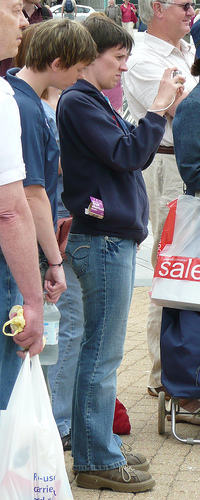

,caption_id,image_file_name,caption
1,0,1295671216_cde1b9c9d1,<start> A crowd of person be stand together on...
943,4,1295671216_cde1b9c9d1,<start> A person in jean and a blue sweatshirt...
21590,1,1295671216_cde1b9c9d1,<start> A guy in a blue sweatshirt take a pict...


In [ ]:
image = "1295671216_cde1b9c9d1.jpg"
images_path = "Flicker8k_Dataset"
path = images_path + "/" + image
from IPython.display import Image, display
z = Image(filename=path)
display(z)

df[df['image_file_name']=='1295671216_cde1b9c9d1']

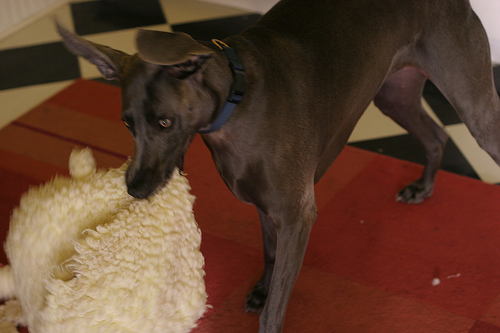

,caption_id,image_file_name,caption
3,1,2949353587_64c54e9589,<start> A brown dog be play with a white fluff...
12699,3,2949353587_64c54e9589,<start> A dark brown dog chew on something whi...
17748,4,2949353587_64c54e9589,<start> A dog tug on a piece of fabric . <end>
23219,0,2949353587_64c54e9589,<start> A brown dog be chew on a white rug whi...


In [ ]:
image = "2949353587_64c54e9589.jpg"
images_path = "Flicker8k_Dataset"
path = images_path + "/" + image
from IPython.display import Image, display
z = Image(filename=path)
display(z)

df[df['image_file_name']=='2949353587_64c54e9589']

In [ ]:
imageCaptionFileDownloaded = drive.CreateFile({'id':'1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1'})
imageCaptionFileDownloaded.GetContentFile('Image_captioning_Dataset.zip')

In [ ]:
ds = df.values

In [ ]:
#unzip and read contents of Flicker8k_Dataset folder
!unzip -u Image_captioning_Dataset

Archive:  Image_captioning_Dataset.zip


In [ ]:
# extracting and saving the features
#directory = 'Flicker8k_Dataset'
#features = extract_features(directory)

In [ ]:
# time consumed so removed, uncomment to train
#pickle.dump(features, open('features.pkl', 'wb'))

In [ ]:
# opens a text file reads it and saves it to an object
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [ ]:
# extracting the captions
def load_captions(doc):
    captions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line)<2:
            continue
        # in the file, the first token of each line is the image id
        image_id, image_caption = tokens[0], tokens[1:]
        # remove the filename from the image id
        image_id = image_id.split('.')[0]
        # convert the image description back into text
        image_caption = ' '.join(image_caption)
        # initiate the list in the dictionary if not already
        if image_id not in captions:
            captions[image_id] = list()
        captions[image_id].append(image_caption)
    return captions
# perform some basic clean up on the captions
def clean_captions(captions):
    for _, captions_list in captions.items():
        for i in range(len(captions_list)):
            caption = captions_list[i]
            # break the caption into words, also makes lowercase
            caption = word_tokenize(caption)
            # removes single characters
            caption = [word for word in caption if len(word)>1]
            # removes punctuation and numbers
            caption = [word for word in caption if word.isalpha()]
            # store again as a string
            captions_list[i] = ' '.join(caption)
    return captions

In [ ]:
# use the captions to generate a vocabulary for the captions
def gen_vocab(captions):
    vocab = set()
    for image_id in captions.keys():
        [vocab.update(word_tokenize(caption)) for caption in captions[image_id]]
    return vocab

In [ ]:
# save the captions to a file to be used again
def save_captions(captions, filename):
    lines = list()
    for image_id, caption_list in captions.items():
        for caption in caption_list:
            lines.append(image_id + ' ' + caption)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [ ]:
captions = {}
for image in df['image_file_name'].unique():
  captionTxt = df[df['image_file_name']==image]['caption']
  image
  captions[image]= captionTxt.tolist()

print('Loaded:', len(captions))

Loaded: 8032


In [ ]:
print('Caption sample:', random.choice(list(captions.items())))

Caption sample: ('3225880532_c8d5d1d798', ['A man wear a red coat with glass look at another man .', 'Two man talk outdoors .', 'A man in a red coat and hat talk to another man in red .', 'A man in a red jacket and hat talk to another man .'])


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
captions = clean_captions(captions)
vocabulary = gen_vocab(captions)
print('Vocab Size:', len(vocabulary))
save_captions(captions, 'captions.txt')

Vocab Size: 5640


# Load and transform data

In [ ]:
# load list of images
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line)<1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [ ]:
def load_formated_captions(filename, dataset):
    doc = load_doc(filename)
    captions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_caption = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in captions:
                captions[image_id] = list()
            caption = 'startseq ' + ' '.join(image_caption) + ' endseq'
            captions[image_id].append(caption)
    return captions

In [ ]:
def load_photo_features(filename, dataset=None):
    all_features = pickle.load(open(filename, 'rb'))
    if dataset:
        features = {k: all_features[k] for k in dataset}
        return features
    else:
        return all_features

In [ ]:
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = df['image_file_name'].unique()
train = set(train.flatten())
print('Dataset:', len(train))
train_captions = load_formated_captions('captions.txt', train)
print('Training Captions:', len(train_captions))
train_features = load_photo_features('features.pkl', train)
print('Training Images:', len(train_features))

Dataset: 8032
Training Captions: 8032
Training Images: 8032


In [ ]:
# creating a tokenizer on the dictionary means we need unpack the dictionary into a list of lists
def create_tokenizer(captions):
    lines = list()
    for caption_list in captions.values():
        [lines.append(caption) for caption in caption_list]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# creating the tokenizer
tokenizer = create_tokenizer(train_captions)
# the dimension that we pass into the algorithms needs to be 1 larger than the vocab size
vocab_dim = len(tokenizer.word_index) + 1
print('vocab_dim:', vocab_dim)

vocab_dim: 5184


In [ ]:
# save the tokenizer
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [ ]:
# getting the max length of the captions
def get_max_length(captions):
    lines = list()
    for caption_list in captions.values():
        [lines.append(caption) for caption in caption_list]
    return max(len(line.split()) for line in lines)

In [ ]:
# transform the data to be used for model training
def gen_Xy(captions, max_length, features, tokenizer):
    # we need two training feature arrays, and a training target array
    X1, X2, y = list(), list(), list()
    # extract these to shape the arrays
    vocab_dim = len(tokenizer.word_index) + 1
    # generate the training features for the text data
    for image_id, caption_list in captions.items():
        for caption in caption_list:
            seq = tokenizer.texts_to_sequences([caption])[0]
            # generate partial sequences
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                # pad the partial sequence for consistent input length
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_dim)[0]
                # store into the training features and target array
                X1.append(features[image_id][0])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
max_length = get_max_length(train_captions)

In [ ]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n_items = take(100, train_captions.items())

In [ ]:
sentences = []
i = 0
for i in range(ds.shape[0]):
    sentences.append(ds[i, 2])
    if i%90==0:
        print(ds[i, 2])
    
print(len(sentences))

<start> A fluffy , tri-colored dog be run down a road with a paper in its mouth . <end>
<start> a bald man with a tattooed head stand next to a man with a brown t-shirt in front of a transparent awning . <end>
<start> a tan dog jog with his tongue hang out <end>
<start> A little girl wear pink be have fun bungee jump . <end>
<start> A boy in blue run away from a woman in blue . <end>
<start> A silhouette of a skateboarder in the air . <end>
<start> A person ski down a snowy hill . <end>
<start> A man sit in front of a wall with art picture on it . <end>
<start> Three girl dance . <end>
<start> A dog run quick through the wood . <end>
<start> A dog run overtop the dry earth . <end>
<start> A blond haired child with blue and red floaties play in the ocean . <end>
<start> A dance girl perform a high kick in a parade . <end>
<start> A goalie block the puck in a field hockey game . <end>
<start> A woman be sit at a beach cover by a lot of seaweed . <end>
<start> A man on the ground near a r

In [ ]:
words = [sentence.split() for sentence in sentences]
i = 0
all_words = []
for k in words:
    for word in k:
        all_words.append(word)
print(all_words[0:40])

unique = list(set(all_words))
print(len(unique))
vocab_size = len(unique)

word_2_indices = {val:index for index,val in enumerate(unique)}
indices_2_word = {index:val for index,val in enumerate(unique)}

word_2_indices['UNK'] = 0
indices_2_word[0] = 'UNK'
print(word_2_indices.keys())

['<start>', 'A', 'fluffy', ',', 'tri-colored', 'dog', 'be', 'run', 'down', 'a', 'road', 'with', 'a', 'paper', 'in', 'its', 'mouth', '.', '<end>', '<start>', 'A', 'crowd', 'of', 'person', 'be', 'stand', 'together', 'on', 'a', 'sidewalk', ',', 'while', 'one', 'man', 'be', 'take', 'a', 'picture', '.', '<end>']
5996
dict_keys(['suspension', 'net', 'excavate', 'enforcment', 'casket', 'dinghy', 'crowd', 'stony', "'s", 'live', 'swine', 'Karate', 'prarie', 'feed', 'surface', 'Day', 'staff', 'Bicyclist', 'spotted', 'fireman', 'shredded', 'possessively', 'hall', 'accross', 'bone', 'disk', 'recreational', 'open-air', 'plant', 'marketplace', 'index', 'messily', 'Easter', 'sea', 'wet', 'than', 'stomach', 'whip', 'enter', 'teenager', 'hunt', 'Wolf-like', 'silly', 'rotate', 'clause', 'Kayacker', 'threaten', 'moss-covered', 'scruffy', 'reflect', 'windsail', 'extremely', 'crib', 'That', 'bus', 'Obama', 'bicycle-cross', 'present', 'wicket', 'tractor', 'double', 'pup', 'power', 'smear', 'hoddie', 'form',

In [ ]:
vocab_size = len(word_2_indices.keys())
max_len = -1
for k in sentences:
    a = k.split(" ")
    
    if len(a)>max_len:
        max_len = len(a)
        arr = a
print(max_len)
print(arr)

40
['<start>', 'An', 'African-american', 'man', 'wear', 'a', 'green', 'sweatshirt', 'and', 'blue', 'vest', 'be', 'hold', 'up', '2', 'dollar', 'bill', 'in', 'front', 'of', 'his', 'face', ',', 'while', 'stand', 'on', 'a', 'busy', 'sidewalk', 'in', 'front', 'of', 'a', 'group', 'of', 'man', 'play', 'instrument', '.', '<end>']


In [ ]:
from keras.preprocessing import image, sequence

padded_sequences = []
subsequent_words = []

for i in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    
    text = ds[i,2].split(" ")
    text = [word_2_indices[i] for i in text]
    
    for i in range(0,len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')
    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
   
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

(24996,)
(24996,)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
#20,36
for x in range(len(padded_sequences[0])):
    array_ = []
    for y in range(max_len):
        array_.append(indices_2_word[padded_sequences[0][x][y]])
    print(array_)
    print("\n")

['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']


['<start>', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']


['<start>', 'A', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']


['<start>', 'A', 'fluffy', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK',

In [ ]:
num_of_images = 2000
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [ ]:
for i in range(num_of_images):
    captions = np.concatenate([captions, padded_sequences[i]])
    next_words = np.concatenate([next_words, subsequent_words[i]])
    if(i%100==0):
        print(i)

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
(27694, 40)
(27694, 5997)


In [ ]:
# transform the training data
X1train, X2train, ytrain = gen_Xy(train_captions, max_length, train_features, tokenizer)
print(X1train.shape, X2train.shape, ytrain.shape)

In [ ]:
# load and transform the testing data
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset:', len(test))
test_captions = load_formated_captions('captions.txt', test)
print('Test Captions:', len(test_captions))
test_features = load_photo_features('features.pkl', test)
print('Test Images:', len(test_features))
X1test, X2test, ytest = gen_Xy(test_captions, max_length, test_features, tokenizer)
print(X1test.shape, X2test.shape, ytest.shape)

# Reference

https://kenanwang.github.io/processed%20data/2020/01/08/photo-captioning.html